# LLMs with RAG for Domain Adaptation

### Get Ready (Install and Import)

***Please choose a GPU runtime.***

In [ ]:
# Install packages silently using quiet mode
!pip install --quiet langchain-core langchain-community langchain-huggingface langgraph chromadb tiktoken pypdf docx2txt -U
!pip install --quiet llama-cpp-python
# Install the sentence_transformers package for obtaining free embeddings
!pip install --quiet sentence_transformers -U
!pip install --quiet ipywidgets -U

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary modules and libraries for document loading, text splitting, embeddings, vector storage, and other functionalities.
from operator import itemgetter
from typing import Any, Dict, List
from termcolor import colored
import os, sys

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from huggingface_hub import hf_hub_download
model_path = hf_hub_download(repo_id="TheBloke/CapybaraHermes-2.5-Mistral-7B-GGUF", filename="capybarahermes-2.5-mistral-7b.Q4_K_M.gguf", cache_dir=".")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)apybarahermes-2.5-mistral-7b.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

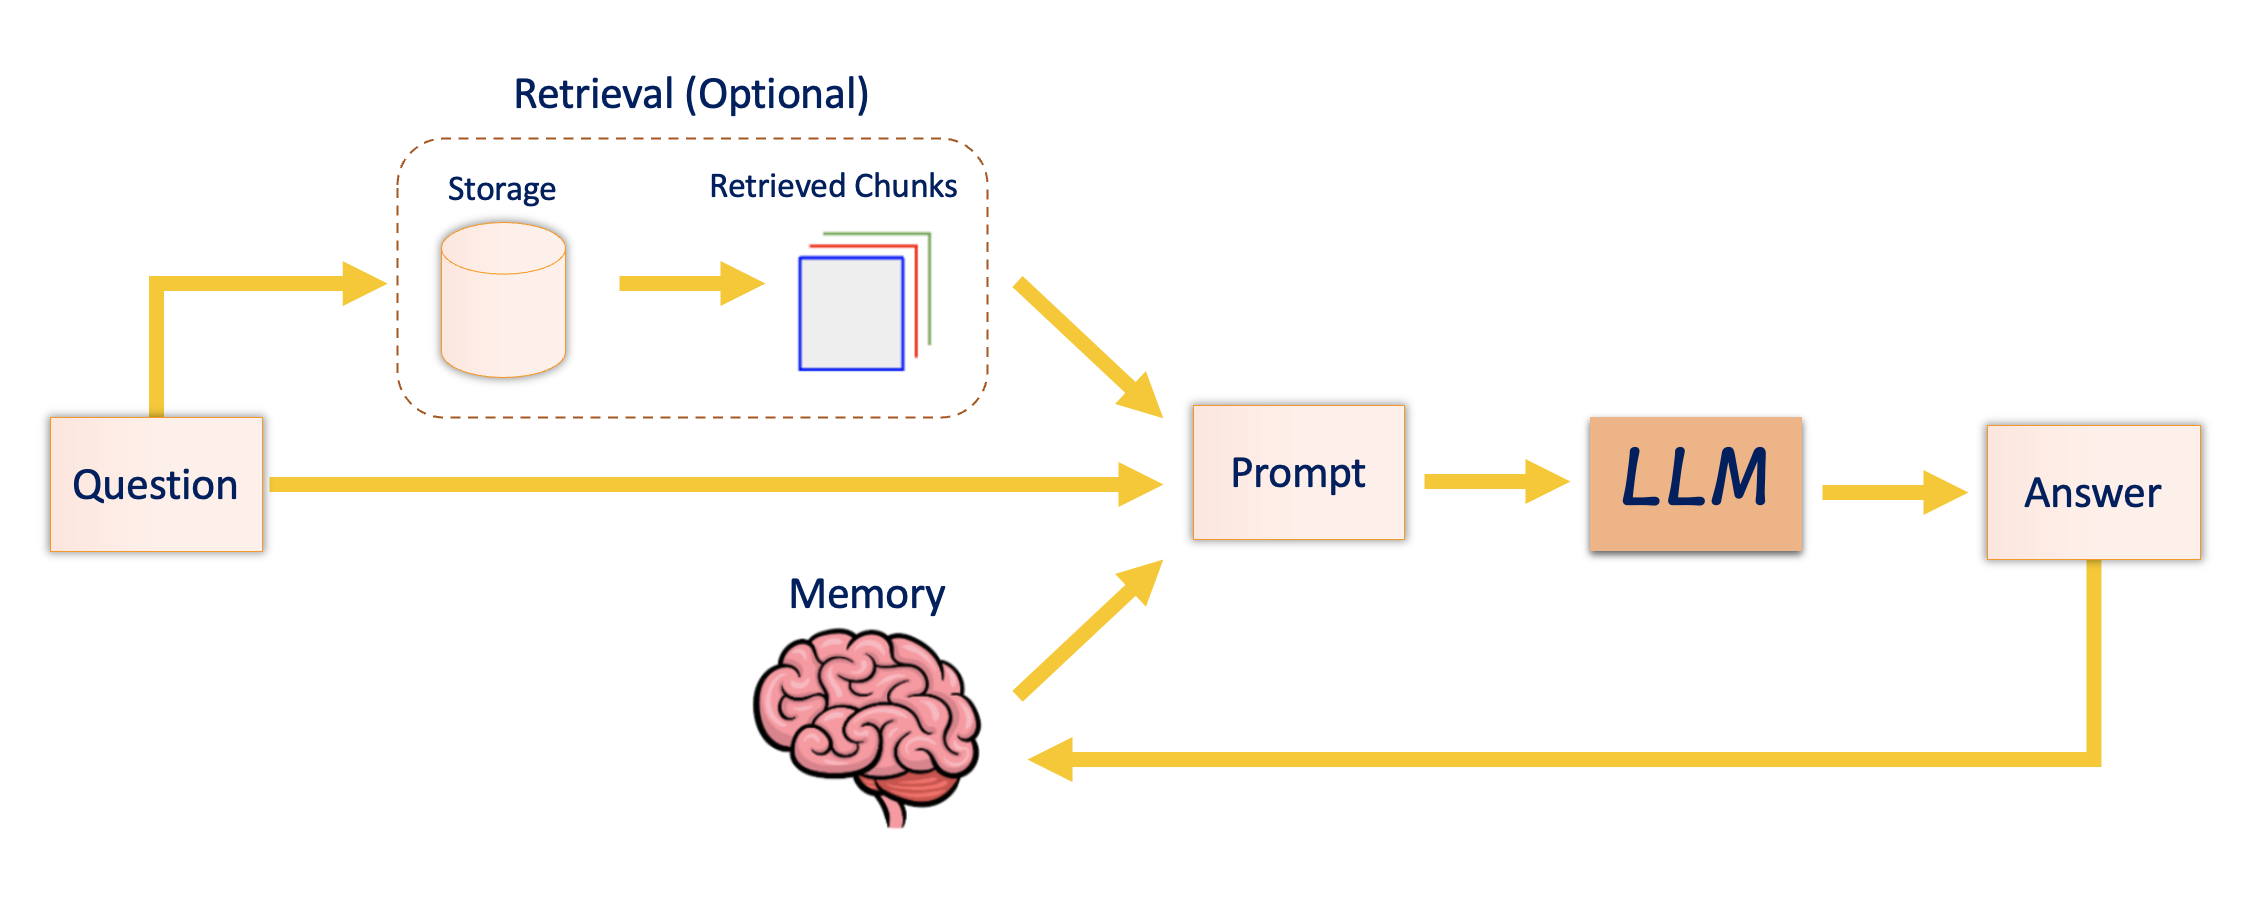

### Read And Split

In [ ]:
from langchain.document_loaders import Docx2txtLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Download necessary data sources
!wget https://ia903405.us.archive.org/5/items/brief-answers-to-the-big-questions/Brief%20Answers%20to%20the%20Big%20Questions.pdf

--2025-01-27 20:11:18--  https://ia903405.us.archive.org/5/items/brief-answers-to-the-big-questions/Brief%20Answers%20to%20the%20Big%20Questions.pdf
Resolving ia903405.us.archive.org (ia903405.us.archive.org)... 207.241.230.195
Connecting to ia903405.us.archive.org (ia903405.us.archive.org)|207.241.230.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2974000 (2.8M) [application/pdf]
Saving to: ‘Brief Answers to the Big Questions.pdf’

Brief Answers to th 100%[===================>]   2.84M  18.4MB/s    in 0.2s    

2025-01-27 20:11:18 (18.4 MB/s) - ‘Brief Answers to the Big Questions.pdf’ saved [2974000/2974000]



In [ ]:
file_paths = [ "./Brief Answers to the Big Questions.pdf"]

In [ ]:
# Iterate through a list of file paths and load text content from PDF, DOC, or DOCX files
text_to_split = []

for file in file_paths:
    if file.endswith('.pdf'):
        print(file)
        # Load text content from a PDF file using PyPDFLoader
        loader = PyPDFLoader(file)
        pdf_file = loader.load()
        text_to_split.append(pdf_file)
    elif file.endswith('.doc') or file.endswith('.docx'):
        # Load text content from a DOC or DOCX file using Docx2txtLoader
        loader = Docx2txtLoader(file)
        doc_file = loader.load()
        text_to_split.append(doc_file)

./Brief Answers to the Big Questions.pdf


In [ ]:
# Initialize an empty list to store the split text chunks
text_splitted = []

# splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=200)

# Choose a text splitter strategy
splitter=RecursiveCharacterTextSplitter(separators=['\n\n', '\n'],
                                    chunk_size=1000,
                                    chunk_overlap=100)


# Iterate through the loaded text content and split it using the chosen text splitter
for t in text_to_split:
    text_chunks = splitter.split_documents(t)
    text_splitted+=  text_chunks

### Retriever

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma


In [ ]:
embeddings = HuggingFaceEmbeddings() # all-mpnet-base-v2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# https://www.datacamp.com/tutorial/chromadb-tutorial-step-by-step-guide
# db.delete_collection()

db=Chroma.from_documents(text_splitted, embeddings)

# Note: If you want to reset the db, don't re-instantiate, but first (del db)

In [ ]:
# Testing the retriever
query = "What is the black hole?"
retriever = db.as_retriever(search_kwargs={"k": 3})
retrieved_docs = retriever.invoke(query)

print(retrieved_docs[0].page_content)

5
WHAT	IS	INSIDE	A	BLACK	HOLE?


### Define LLM

In [ ]:
from langchain.llms import LlamaCpp
from langchain.prompts import  ChatPromptTemplate
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.memory import ConversationSummaryMemory, ConversationSummaryBufferMemory, ConversationBufferWindowMemory, ConversationBufferMemory

In [ ]:
class CustomCallbackHandler(StreamingStdOutCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs: Any) -> None:
        # Assuming response is a string
        colored_token = colored(token, 'blue')
        sys.stdout.write(colored_token)
        sys.stdout.flush()


# from IPython.display import HTML, display
# import sys

# class CustomCallbackHandler(StreamingStdOutCallbackHandler):
#     def on_llm_new_token(self, token: str, **kwargs: Any) -> None:
#         # Assuming response is a string
#         colored_token = '<font color="blue">{}</font>'.format(token)
#         display(HTML(colored_token))


callback_manager = CallbackManager([CustomCallbackHandler()])

In [ ]:
def load_llm():
  # The number of layers of the model that are offloaded to your GPU (Graphics Processing Unit).
  # In a transformer (LLM) model, the model architecture is often composed of multiple layers. Each layer performs a specific transformation on the input data.
  # Offloading layers to the GPU can significantly accelerate computations, as GPUs are optimized for parallel processing.
  n_gpu_layers = -1  # Metal set to 1 is enough. If -1, all layers are offloaded.

  # how many tokens are processed in parallel for prediction, default is 8. You can set to a bigger number
  n_batch = 512  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip / CUDA GPU.

  # The context size is the maximum number of tokens that the model can account for when processing a response. this includes the prompt, and the response itself, so the context needs to be set large enough for both the question, and answer. The important thing to note, is that the model must process its own response as part of the context in order to write it, since it can only predict one token at a time
  # Most models are trained with a context size of 2048. Going over a models context limit is advised against, since it hasn't been trained to account for data sets larger than its suggested context limit.
  # If n_ctx is set higher than 512, the model will process the input in chunks of 512 tokens at a time.
  # This means it will generate text based on the most recent 512 tokens of context, potentially leading to inconsistencies if the context spans beyond that window.
  n_ctx = 7000

  #   if top_k > 0: keep only top k tokens with highest probability (top-k filtering). (I didn't use here)
  top_k = None

  #   if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
  top_p = 0.8

  # Number of tokens to generate
  # Default: Unlimited, depending on n_ctx.
  max_tokens = 4000

  # Explained in the slides
  temperature = 0.2

  llm = LlamaCpp(
      model_path=model_path,
      n_gpu_layers=n_gpu_layers,
      n_batch=n_batch,
      f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls if Metal.
      callbacks=callback_manager,
      n_ctx=n_ctx,
      verbose=False,
      max_tokens=max_tokens,
      temperature=temperature, # Critical for good results
      top_p=top_p,
      stop=["#", "HumanMessage", "AIMessage","Human:", "AI:",'\n\n\n']
  )
  return llm


if 'llm' in globals():
      del llm
llm = load_llm() # If the model cannot load, then try (del llm), it might be a memory-related issue

llama_new_context_with_model: n_ctx_per_seq (7008) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


In [ ]:
?LlamaCpp

### Memory

In [ ]:
# Notice that we `return_messages=True` to fit into the MessagesPlaceholder
# Notice that `"chat_history"` aligns with the MessagesPlaceholder name
# memory = ConversationSummaryMemory(
#     llm=llm, memory_key="chat_history", return_messages=True, output_key="answer", input_key="question"
# )

# Difference between return_messages and not: https://python.langchain.com/v0.1/docs/modules/memory/types/buffer/


memory = ConversationBufferMemory(k=4, return_messages=False)


In [ ]:
template = """Given the following conversation and a follow up question, Answer the question based only on the following context:

Context: {context}

Current Conversation:
{chat_history}

HumanMessage: ({input})
AIMessage:"""

prompt = ChatPromptTemplate.from_template(template)

### Usage

In [ ]:
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

In [ ]:
def load_chain_rag():

    template = """Answer the question based only on the following context:

    Context: {context}

    Current Conversation:
    {chat_history}

    Human: {input}
    AI:"""

    prompt = ChatPromptTemplate.from_template(template)


    llm = load_llm()

    memory = ConversationBufferMemory(k=3, return_messages=False)

    retriever = db.as_retriever(k=3)

    chain = (
    {
        "context": itemgetter("input") | retriever,
        "input": itemgetter("input"),
    }
    |
    RunnablePassthrough.assign(
        chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    )
    | prompt
    | llm
    )
    return chain, memory

In [ ]:
def load_chain():

    template = """Answer the question based only on the following context:

    Current Conversation:
    {chat_history}

    Human: {input}
    AI:"""

    prompt = ChatPromptTemplate.from_template(template)

    memory = ConversationBufferMemory(k=4, return_messages=False)

    chain = (
    RunnablePassthrough.assign(
        chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    )
    | prompt
    | llm
    )
    return chain, memory



In [ ]:
if 'llm' in globals():
  del llm

In [ ]:
chain, memory = load_chain_rag()

while True:
    query = input("Human: ")
    inputs = {"input": query}

    print(colored("Virtual Assistant: ", 'blue'), end="")
    response = chain.invoke(inputs)

    if response=="":
        response = chain.invoke(inputs)

    memory.save_context(inputs, {"output": response})


# Is falling into a black hole bad news for a space traveller?

# Is falling into a black hole bad news for a space traveller? Answer in one word

# Why did you take long time to respond?

# So, what are the four possibilities for other intelligent life in the universe?


llama_new_context_with_model: n_ctx_per_seq (7008) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


Virtual Assistant:  The book is about a project that the author worked on in the last year of his life. The idea was to bring contemporary writings together into one volume. Like so many things that have happened since the author's death, he wished he could have seen it.

    

In [ ]:
chain, memory = load_chain()
while True:
    query = input("Human: ")
    inputs = {"input": query}

    print(colored("Virtual Assistant: ", 'blue'), end="")
    response = chain.invoke(inputs)

    if response.strip() in ["", "$"]:
        response = chain.invoke(inputs)

    memory.save_context(inputs, {"output": response})


<ipython-input-20-dbe7a8b4aee1>:13: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(k=4, return_messages=False)


Human: How are you?
Virtual Assistant:  I am doing well. How about you?
    

KeyboardInterrupt: Interrupted by user

# Do More

In [ ]:
# Takes around 5 minutes to finish running and scraping the webpages
from langchain.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import HTMLHeaderTextSplitter

from bs4 import BeautifulSoup
import aiohttp
import requests
from typing import Union
import re

# https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.recursive_url_loader.RecursiveUrlLoader.html

def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    text = re.sub(r"\n\n+", "\n\n", soup.text)
    text = re.sub(r"\s+", " ", text)          # Replace all whitespaces with a single space
    return text.strip()

def simple_metadata_extractor(
    raw_html: str, url: str, response: Union[requests.Response, aiohttp.ClientResponse]
) -> dict:
    content_type = getattr(response, "headers").get("Content-Type", "")
    return {"source": url, "content_type": content_type}

loader = RecursiveUrlLoader(
    "https://website.cs.vt.edu/Undergraduate/courses.html",
    max_depth=2,
    # extractor=lambda x: Soup(x, "html.parser").text,
    timeout = 600,
    prevent_outside = False,
     metadata_extractor = simple_metadata_extractor, extractor = bs4_extractor
)
data = loader.load()



In [ ]:

headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
    ("h3", "Header 3"),
]

html_splitter = HTMLHeaderTextSplitter(
    headers_to_split_on,
    return_each_element=True,
)
# Iterate through the loaded text content and split it using the chosen text splitter

text_splitted = splitter.split_documents(data)

chunk_size = 1000
chunk_overlap = 30
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
text_splitted = text_splitter.split_documents(text_splitted)


In [ ]:
text_splitted

In [ ]:
# Chroma appears to fail to handle datetimes or non-str types
for doc in text_splitted:
    for md in doc.metadata:
        doc.metadata[md] = str(doc.metadata[md])

In [ ]:
# https://www.datacamp.com/tutorial/chromadb-tutorial-step-by-step-guide
db.delete_collection()
db=Chroma.from_documents(text_splitted, embeddings)

# Note: If you want to reset the db, don't re-instantiate, but first # db.delete_collection()

In [ ]:
for d in data:
  print(d.metadata['source'])

In [ ]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
chain, memory = load_chain_rag()

while True:
    query = input("Human: ")
    inputs = {"input": query}

    print(colored("Virtual Assistant: ", 'blue'), end="")
    response = chain.invoke(inputs)

    if response=="":
        response = chain.invoke(inputs)

    memory.save_context(inputs, {"output": response})


# Human:  what do you know about CS4624: Multimedia, Hypertext and information Access?

In [ ]:
chain, memory = load_chain()
while True:
    query = input("Human: ")
    inputs = {"input": query}

    print(colored("Virtual Assistant: ", 'blue'), end="")
    response = chain.invoke(inputs)

    if response.strip() in ["", "$"]:
        response = chain.invoke(inputs)

    memory.save_context(inputs, {"output": response})


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!cd "/content/drive/MyDrive/Colab Notebooks"
!ls

drive  sample_data


In [3]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
                   --to notebook \
                   --inplace Applied_RAG_Pipeline_with_LLaMA_and_ChromaDB.ipynb


[NbConvertApp] WARNING | pattern 'Applied_RAG_Pipeline_with_LLaMA_and_ChromaDB.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterA